## Introduction to Computer Vision (Spring 2021)

Instructors: Muhammad Fahim, Riby A. B.


**Acknowledgement**<br>
This lab was maintained by Riby A. B., Marcus, Rufina, Alex and Fahim
<br><br>

This lab was created by: Alex<br>
Email: a.grashchenkov@innopolis.ru<br>
Links: [github](https://github.com/AlexandrGraschenkov)

## Lab Objectives
Bag of visual Words(BOW), 

## Import libraries, download images

In [1]:
from IPython.display import clear_output
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
# clear_output()

In [2]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
# remove grid lines
import numpy as np
import time
import cv2
import math

## Download images

In [3]:
!wget https://сезоны-года.рф/sites/default/files/images/shkolnikam/gora.jpg -O mountains.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/mouse.jpg?raw=true -O mouse.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/mouse_scene.jpg?raw=true -O mouse_scene.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/panorama1.jpg?raw=true -O panorama1.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/panorama2.jpg?raw=true -O panorama2.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book.jpg?raw=true -O book.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book_scene.jpg?raw=true -O book_scene.jpg
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book_scene_2.jpg?raw=true -O book_scene_2.jpg
clear_output()

## Helper functions

In [4]:
# funcrion to read and resize an image
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

    
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  # set inline plots size
  plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()
  
def show_in_column(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  # set inline plots size
  plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
  for idx in range(count):
    subplot = plt.subplot(count, 1, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

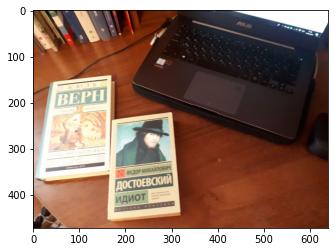

In [5]:
book_scene = read_and_resize("book_scene.jpg")
plt.imshow(book_scene)
plt.show()

Sample information for 1-st kepypoint out of 871 keypoints 
 Pos: (3.8406548500061035, 180.36634826660156) 
Size: 3.106300115585327 
Angle: 64.41616821289062
Descriptor shape: (128,)


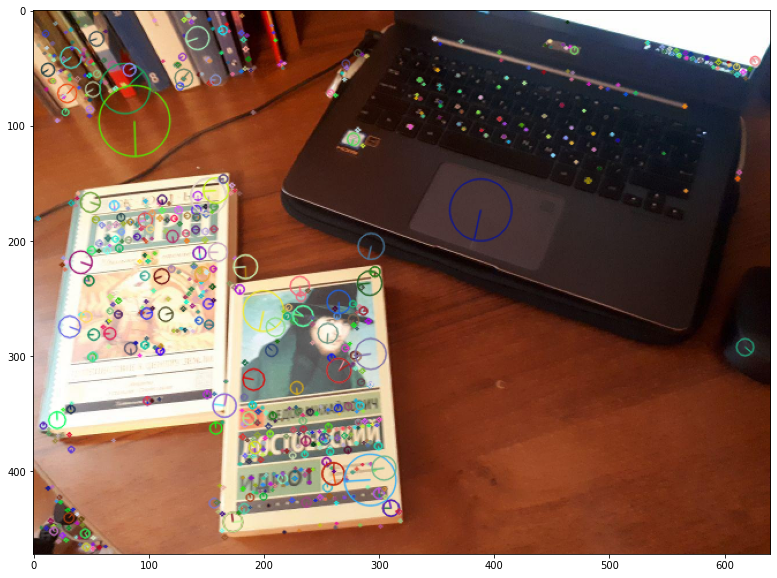

In [93]:

def processSIFT(img):
  sift = cv2.xfeatures2d.SIFT_create()
  return sift.detectAndCompute(img, None)

kp, descriptors = processSIFT(book_scene)
kp, descriptors = processSIFT(book_scene)
#details of kepoint https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html#a1f163ac418c281042e28895b20514360
print("Sample information for 1-st kepypoint out of {} keypoints \n Pos:".format(len(kp)),kp[0].pt, "\nSize:", kp[0].size, "\nAngle:", kp[0].angle)
print("Descriptor shape:", descriptors[0].shape)
book_scene_desc = cv2.drawKeypoints(book_scene, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_in_row([book_scene_desc])


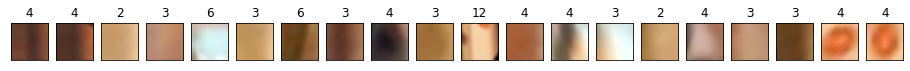

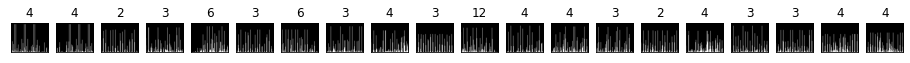

In [8]:
#crops a squaere window of 2*size of the keypoint along direction of angle
def crop_rect(img, rect, dst_size=(20, 20)):
  center, size, angle = rect[0], rect[1], rect[2]
  center, size = tuple(map(int, center)), tuple(map(int, size))


  height, width = img.shape[0], img.shape[1]
  #center is detected coordinate of keypoint, angle is direction of maximum value in histogram, dst_size is the final height of the cropped image
  M = cv2.getRotationMatrix2D(center, angle, dst_size[0] / size[0])# whole image is rotated wrt the direction, scaling is done wrt ratio of destination size  and keypoint size, after which area is cropped
  img_rot = cv2.warpAffine(img, M, (width, height))

  img_crop = cv2.getRectSubPix(img_rot, dst_size, center)
  return img_crop

#create an image to represent the histogram
def visualize_hist(vec, height = 100, bin_width = 3, ndivision = None):
  img = np.zeros((height, bin_width * len(vec)), dtype='uint8')
  if ndivision is None: ndivision = np.max(vec)
  for idx, val in enumerate(vec):
    val = math.ceil(val *  height/ ndivision)
    if val > 0: img[-val:, idx*bin_width:(idx+1)*bin_width] = 255
  return img

#crop the region of keypoint according to its size
def get_kp_img(img, k):
  return crop_rect(img, (k.pt, (2*k.size, 2*k.size), k.angle))
  

def show_key_point_and_hist(img, key_points, descs):
  img_list = []
  hist_list = []
  info_list = []
  for idx, k in enumerate(key_points):
    cimg = get_kp_img(img, k)
    img_list.append(cimg)
    hist_img = visualize_hist(descs[idx], height = 300, ndivision = 200)
    hist_list.append(hist_img)
    info_list.append(str(math.ceil(k.size)))
  show_in_row(img_list, info_list, True)
  show_in_row(hist_list, info_list, True)
 
from_idx = 0
to_idx = from_idx+20
show_key_point_and_hist(book_scene, kp[from_idx:to_idx], descriptors[from_idx:to_idx])

# plt.plot(descriptors[0])
# plt.show()

## Implement vector distance metric
From slides:
![alt text](https://drive.google.com/uc?export=view&id=1sggfpcQvkbkYnIrQ50EcMvRso4VLekL6)

In [13]:
from scipy.spatial import distance
def euclid_dist(v1, v2):
  diff = v1 - v2
  return np.sum(diff ** 2) ** 0.5

def cosine_dist(v1, v2):
  # TODO
  distance = 1 - (v1 @ v2.T)/ ((np.sum(v1 ** 2 )** 0.5) * (np.sum(v2 ** 2 )** 0.5))
  return distance
print('Distances:')
for i in range(1, 5):
  d1 = euclid_dist(descriptors[i-1], descriptors[i])
  d2 = cosine_dist(descriptors[i-1], descriptors[i])
  print(d3)
  print("From {} to {}, Euclidean: ".format(i-1,i), d1, "Cosine: ", d2)

Distances:
0.5887491703033447
From 0 to 1, Euclidean:  367.3526915649319 Cosine:  0.2576336679190485
0.5887491703033447
From 1 to 2, Euclidean:  560.4507114813933 Cosine:  0.5996853656228787
0.5887491703033447
From 2 to 3, Euclidean:  469.09487313335666 Cosine:  0.41942965730375803
0.5887491703033447
From 3 to 4, Euclidean:  555.9352480280414 Cosine:  0.5887491656633801


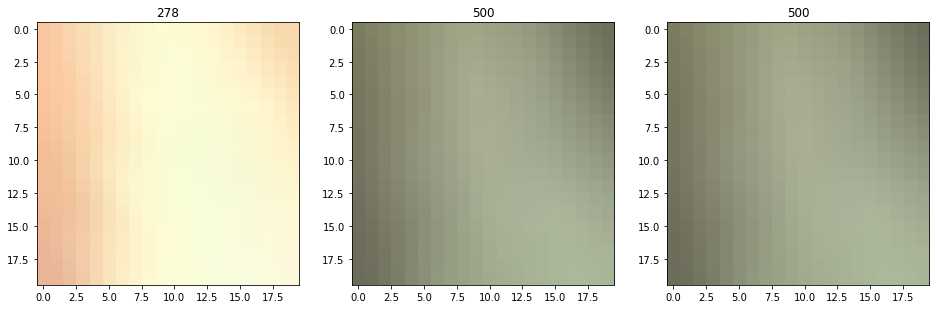

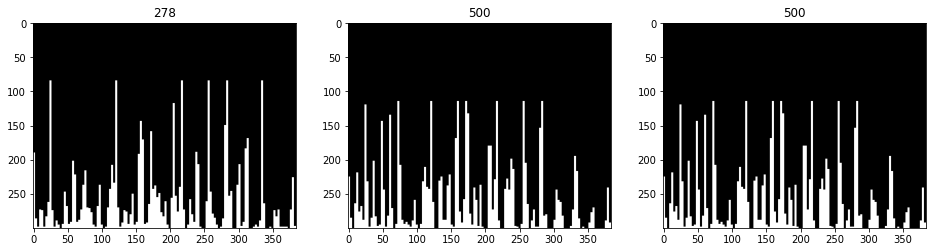

In [31]:
def find_closest_idx(desc, idx, metric):
  # TODO
  min_dist = metric(descriptors[idx], descriptors[idx+1])
  min_idx = idx+1
  for i in range(descriptors.shape[0]):
    if idx != i:
      if metric == euclid_dist:
        dist = euclid_dist(descriptors[idx], descriptors[i])
      else:
        dist = cosine_dist(descriptors[idx], descriptors[i])
      if dist < min_dist:
        min_dist = dist
        min_idx = i
  return min_idx



In [77]:
def show_keypoints(kp, descs, indexes):
  show_in_row([get_kp_img(book_scene, kp[i]) for i in indexes], [str(i) for i in indexes])
  show_in_row([visualize_hist(descriptors[i], height = 300, ndivision= 200) for i in indexes], [str(i) for i in indexes])

In [ ]:
def show_closest_keypoints(kp, descs, idx):
  idx_euclid = find_closest_idx(descriptors, idx, euclid_dist)
  idx_cos = find_closest_idx(descriptors, idx, cosine_dist)

  indexes = [idx, idx_euclid, idx_cos]
  show_keypoints(kp, descs, indexes)

  
show_closest_keypoints(kp, descriptors, 278)

# KMean clustering
![alt text](http://mnemstudio.org/ai/cluster/images/k-means1.gif)

1) Initalize centroids at random points<br>
2) Assign points to closest centroid<br>
3) Move centroids to avg value of its points<br>
4) Repeat steps 2-3 N times<br>
5) Final result when the change in centroid stabilizes<br>

In [127]:
# TODO
def find_closest_idx(descriptors, desc, metric):
  # TODO
  min_dist = metric(desc, descriptors[0])
  min_idx = 0
  for i in range(1, descriptors.shape[0]):
    if metric == euclid_dist:
      dist = euclid_dist(desc, descriptors[i])
    else:
      dist = cosine_dist(desc, descriptors[i])
    if (dist < min_dist):
      min_dist = dist
      min_idx = i
  
  return min_idx














iteration:   0%|          | 0/30 [00:00<?, ?it/s]











iteration:   3%|▎         | 1/30 [00:02<01:07,  2.34s/it]











iteration:   7%|▋         | 2/30 [00:04<01:06,  2.38s/it]











iteration:  10%|█         | 3/30 [00:07<01:03,  2.37s/it]











iteration:  13%|█▎        | 4/30 [00:09<01:01,  2.37s/it]











iteration:  17%|█▋        | 5/30 [00:11<00:59,  2.39s/it]











iteration:  20%|██        | 6/30 [00:14<00:57,  2.39s/it]











iteration:  23%|██▎       | 7/30 [00:16<00:54,  2.39s/it]











iteration:  27%|██▋       | 8/30 [00:19<00:52,  2.38s/it]











iteration:  30%|███       | 9/30 [00:21<00:49,  2.38s/it]











iteration:  33%|███▎      | 10/30 [00:23<00:47,  2.39s/it]











iteration:  37%|███▋      | 11/30 [00:26<00:45,  2.38s/it]











iteration:  40%|████      | 12/30 [00:28<00:42,  2.37s/it]











iteration:  43%|████▎     | 13/30 [00:30<00:40,  2.36s/it]











iteration:  47%|████▋     

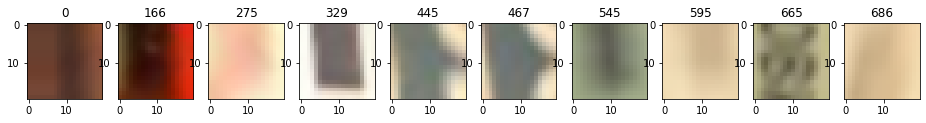

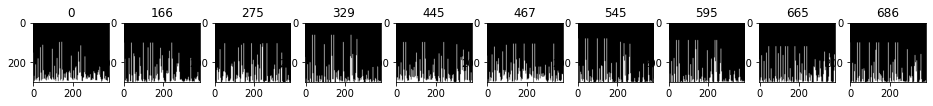

In [134]:
from tqdm import tqdm


def kmeans(descriptors, clusters_count, metric, iterations = 50, ):
  # returns list of clustered point indexes
  # return list(list(int))
  # step 1
  clusters = descriptors[:clusters_count] 
  clusters_indexes = [i for i in range(clusters_count)]
  
  
  for iter_idx in tqdm(range(iterations), desc="iteration"):  
    # step 2
    List_clusters = [ [] for i in range(clusters_count) ]
    for desc_idx in range(descriptors.shape[0]):

      idx = find_closest_idx(clusters, descriptors[desc_idx], metric)
      List_clusters[idx].append(desc_idx)

    # #step 3

    for cluster_idx in range(clusters_count):
      cluster_matrix = np.zeros((128))
      for vector_in_cluster in List_clusters[cluster_idx]:
        cluster_matrix  = cluster_matrix + descriptors[vector_in_cluster] 
      mean = np.divide(cluster_matrix, float(len(List_clusters[cluster_idx])))
      clusters[cluster_idx] = mean
    

  return List_clusters

clusters = kmeans(descriptors, 100, cosine_dist, 30)

show_keypoints(kp, descriptors, clusters[0][:10])

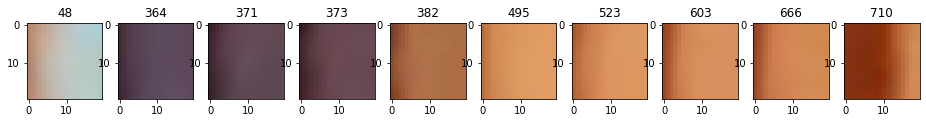

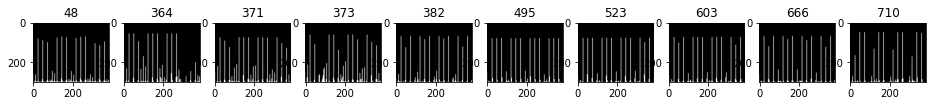

In [158]:
show_keypoints(kp, descriptors, clusters[48][:10])

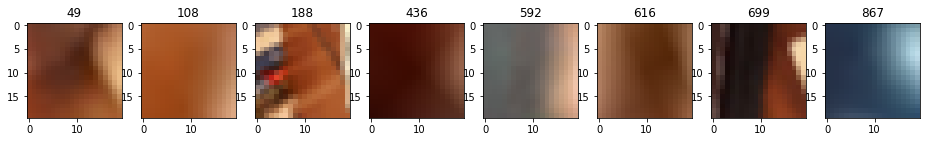

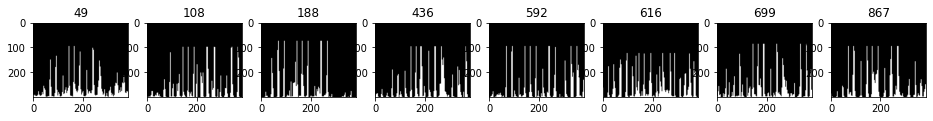

In [159]:
show_keypoints(kp, descriptors, clusters[49][:10])

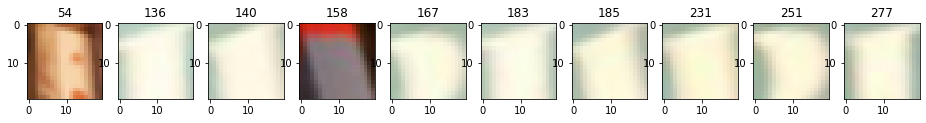

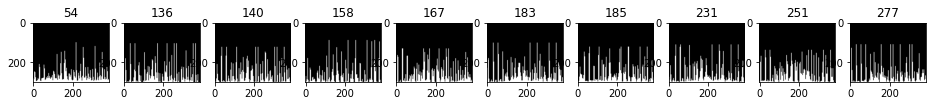

In [164]:
show_keypoints(kp, descriptors, clusters[54][:10])

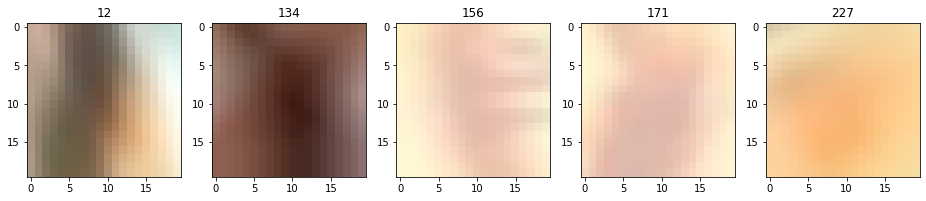

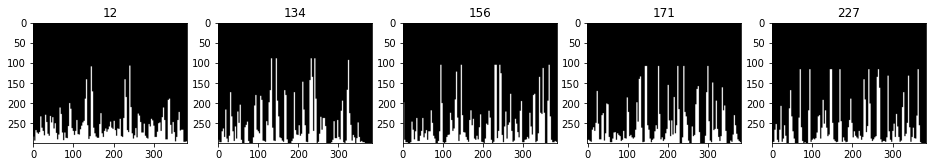

In [169]:
show_keypoints(kp, descriptors, clusters[12][:5])

Reference

B. Lowe, Distinctive Image Featuresfrom Scale-Invariant Keypoints, https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf